In [82]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import sys

sys.path.append(os.path.join(os.getenv("HOME"), "gpuaffman_networks/"))
import ragged_general_network, general_network_visualization


The parameters of a ragged kauffman network are the number of nodes $N$ and the maximum number of connections to each node $k_{max}$.


In [83]:
N = 10
k_max = 3

A network is completely specified by 3 arrays:

1. A $N$ x $2^{k_{max}}$ binary matrix representing the binary function that updates each node
2. A $N$ x $k_{max}$ integer matrix representing the connections made to each node
3. A $N$ x $k_{max}$ binary matrix representing the active connections, whcih serves to mask (2)


In [88]:
np.random.seed(1323435)
functions = np.random.binomial(1, 0.5, (N, 1 << k_max)).astype(np.bool_)
connectivity = np.random.randint(0, N, (N, k_max)).astype(np.uint8)
used_connectivity = np.random.binomial(1, 0.5, (N, k_max)).astype(np.bool_)

In [94]:
print(np.matrix(functions))
print()
print(np.matrix(connectivity))
print()
print(np.matrix(used_connectivity))


[[ True  True  True  True False False  True False]
 [False  True False  True False  True False False]
 [False  True  True False  True False False  True]
 [ True False False  True  True  True  True False]
 [False False  True False False False False  True]
 [ True False  True False  True  True False False]
 [False False  True False False  True False  True]
 [ True  True  True False False  True False False]
 [ True  True False  True  True  True  True  True]
 [ True False  True False False False False False]]

[[3 4 0]
 [6 4 6]
 [1 9 9]
 [4 3 8]
 [3 0 2]
 [4 4 5]
 [4 7 2]
 [3 7 0]
 [3 3 2]
 [4 5 8]]

[[ True  True  True]
 [False  True  True]
 [False False False]
 [ True False False]
 [False  True  True]
 [ True  True False]
 [False  True False]
 [ True  True  True]
 [ True  True False]
 [ True  True  True]]


This can be visualized as a directed graph. The direction of the edges indicates the direction of information flow through the network. The head node is updated by each tail node at every timestep.


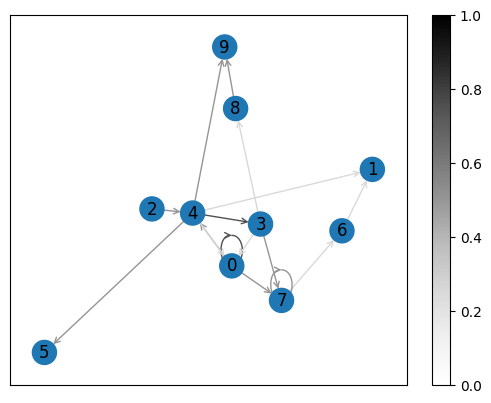

In [90]:
fig, axs = plt.subplots()
g = general_network_visualization.influence_graph_from_ragged_spec(functions, connectivity, used_connectivity)
pos = nx.spring_layout(g)
general_network_visualization.plot_network_directed(g, pos, axs, ["C0"] * N, colorbar=True)

The color of the edge indicates the influence of the tail node on the head node. If the influence is 1, flipping the tail node always leads to flipping the head node. If it is 0, flipping the tail node has no effect on the head node (and the connection is effectively inactive).


Given these 3 matricies and an initial state, we can simulate the trajectory of the network for all future times.


Text(0, 0.5, 'Time')

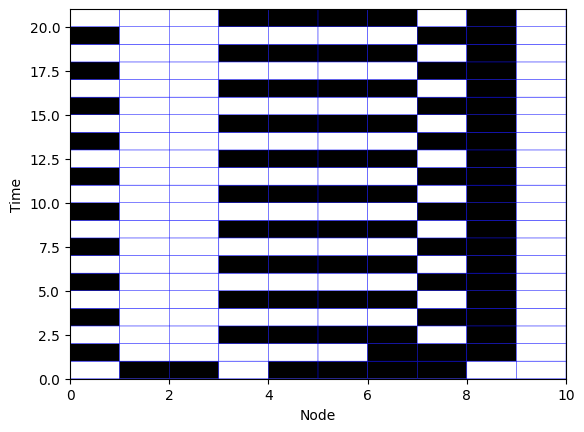

In [98]:
fig, axs = plt.subplots()
n_steps = 20
init_state = np.random.binomial(1, 0.5, N).astype(np.bool_)
all_states = np.moveaxis(np.tile(np.expand_dims(init_state, -1), n_steps+1), -1, 0)
for i in range(n_steps):
    all_states[i+1] = ragged_general_network.ragged_k_state_update(all_states[i], functions, connectivity, used_connectivity)
axs.pcolor(all_states, cmap="Greys", linewidth=0.3, edgecolors="blue")
axs.set_xlabel("Node")
axs.set_ylabel("Time")

We can run on an NVIDIA GPU using cupy:


In [99]:
import cupy as cp

In [100]:
init_state_cp = cp.array(init_state)
functions_cp = cp.array(functions)
connectivity_cp = cp.array(connectivity)
used_connectivity_cp = cp.array(used_connectivity)

In [101]:
_ = ragged_general_network.ragged_k_state_update(init_state_cp, functions_cp, connectivity_cp, used_connectivity_cp)
